01:50:40 - cmdstanpy - INFO - Chain [1] start processing
01:50:47 - cmdstanpy - INFO - Chain [1] done processing


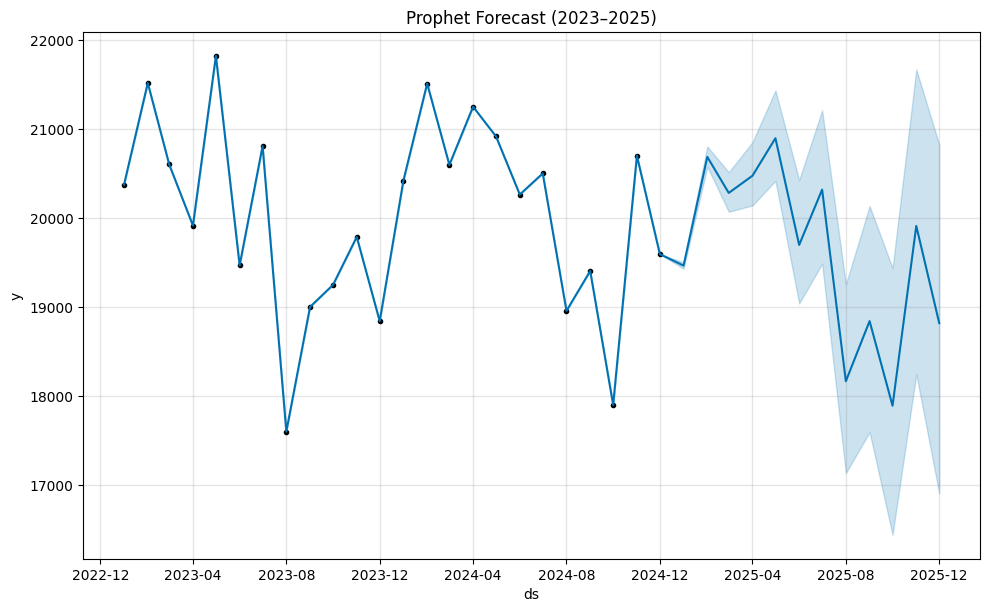

/Users/ashikurrahmanshihab/fbProphet/.venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



Reorder Point Forecast (2025):
           ds          yhat  safety_stock           ROP
24 2025-01-01  19467.831785     29.374992  19497.206777
25 2025-02-01  20689.743441     93.609775  20783.353216
26 2025-03-01  20284.821558    183.191952  20468.013510
27 2025-04-01  20478.017376    293.002073  20771.019449
28 2025-05-01  20899.805365    418.891768  21318.697133
29 2025-06-01  19700.614129    572.201470  20272.815598
30 2025-07-01  20321.958084    710.991760  21032.949844
31 2025-08-01  18169.023380    874.620273  19043.643653
32 2025-09-01  18844.663482   1047.878641  19892.542124
33 2025-10-01  17893.754168   1236.007138  19129.761307
34 2025-11-01  19914.207180   1412.366909  21326.574089
35 2025-12-01  18822.002516   1617.099549  20439.102065

Hybrid Reorder Point Forecast (2025):
           ds  hybrid_forecast  hybrid_safety_stock    hybrid_ROP
24 2025-01-01     19467.820862            29.374992  19497.195854
25 2025-02-01     20689.753018            93.609775  20783.362793
26 

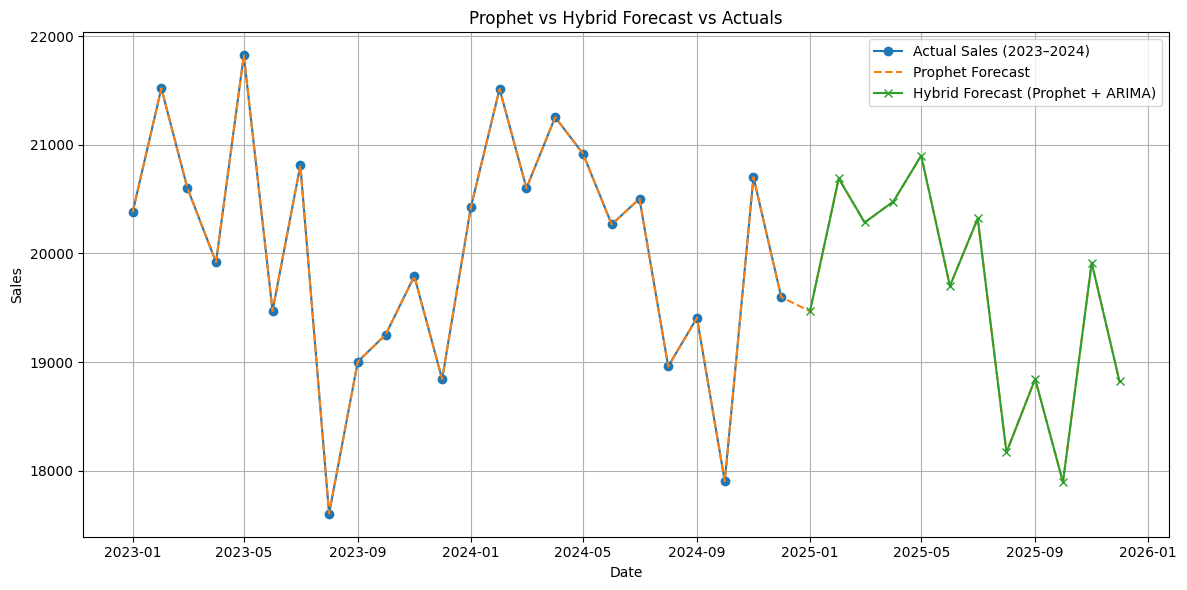

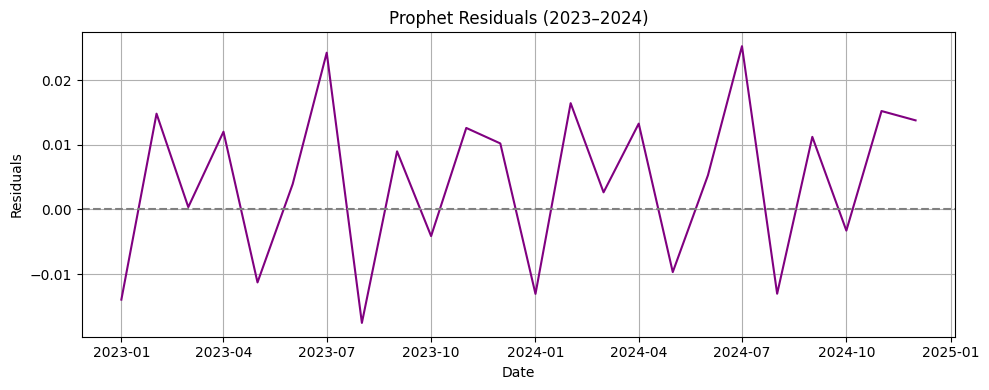

In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# -----------------------------
# Step 1: Data Preparation
# -----------------------------
# Simulated monthly sales data (Jan 2023 – Dec 2024)
months = pd.date_range(start='2023-01-01', end='2024-12-01', freq='MS')
sales = 20000 + 1000 * np.sin(2 * np.pi * months.month / 12) + np.random.normal(0, 800, len(months))

df = pd.DataFrame({
    'year': months.year,
    'month': months.month,
    'sales': sales
})

# Combine year and month into a 'ds' column
df['ds'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
df['y'] = df['sales']
df = df[['ds', 'y']].sort_values('ds').reset_index(drop=True)

# -----------------------------
# Step 2: Forecasting with Prophet
# -----------------------------
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)
model.fit(df)

# -----------------------------
# Step 3: Making Future Prediction
# -----------------------------
future = model.make_future_dataframe(periods=12, freq='MS')  # Jan 2025 to Dec 2025
forecast = model.predict(future)

# Plot forecast
model.plot(forecast)
plt.title("Prophet Forecast (2023–2025)")
plt.show()

# -----------------------------
# Step 4: Calculating Reorder Point
# -----------------------------
# Parameters
LEAD_TIME_MONTHS = 1
SERVICE_LEVEL_Z = 1.65  # For 95%
forecast_2025 = forecast[forecast['ds'].dt.year == 2025].copy()
forecast_2025['forecast_std'] = (forecast_2025['yhat_upper'] - forecast_2025['yhat_lower']) / 4  # Approx std
forecast_2025['safety_stock'] = SERVICE_LEVEL_Z * forecast_2025['forecast_std']
forecast_2025['ROP'] = forecast_2025['yhat'] + forecast_2025['safety_stock']

# Display ROP
print("\nReorder Point Forecast (2025):")
print(forecast_2025[['ds', 'yhat', 'safety_stock', 'ROP']])

# -----------------------------
# Step 5: Calculating Forecast Errors (Residuals)
# -----------------------------
# Merge historical forecast with actuals
historical = forecast[forecast['ds'] <= '2024-12-01'][['ds', 'yhat']].copy()
merged = pd.merge(df, historical, on='ds')
merged['residuals'] = merged['y'] - merged['yhat']

# -----------------------------
# Step 6: Using ARIMA to Model Residuals
# -----------------------------
# Fit ARIMA model on residuals
arima_model = ARIMA(merged['residuals'], order=(1, 0, 1))
arima_result = arima_model.fit()

# Forecast ARIMA residuals for 12 months
arima_forecast = arima_result.forecast(steps=12)

# -----------------------------
# Step 7: Combining Prophet + ARIMA Forecasts (Hybrid Model)
# -----------------------------
forecast_2025['arima_residuals'] = arima_forecast.values
forecast_2025['hybrid_forecast'] = forecast_2025['yhat'] + forecast_2025['arima_residuals']

# -----------------------------
# Step 8: Final ROP Calculation Using Hybrid Forecast
# -----------------------------
forecast_2025['hybrid_std'] = forecast_2025['forecast_std']  # For now, use same std
forecast_2025['hybrid_safety_stock'] = SERVICE_LEVEL_Z * forecast_2025['hybrid_std']
forecast_2025['hybrid_ROP'] = forecast_2025['hybrid_forecast'] + forecast_2025['hybrid_safety_stock']

# Display final ROP
print("\nHybrid Reorder Point Forecast (2025):")
print(forecast_2025[['ds', 'hybrid_forecast', 'hybrid_safety_stock', 'hybrid_ROP']])

# -----------------------------
# Step 9: Forecast Accuracy Comparison
# -----------------------------
y_true = merged['y']
y_pred = merged['yhat']
resid = merged['residuals']

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print("\nForecast Accuracy (Prophet):")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²:   {r2:.4f}")

# -----------------------------
# Step 10: Visualization and Interpretation
# -----------------------------
plt.figure(figsize=(12, 6))
plt.plot(df['ds'], df['y'], label='Actual Sales (2023–2024)', marker='o')
plt.plot(forecast['ds'], forecast['yhat'], label='Prophet Forecast', linestyle='--')
plt.plot(forecast_2025['ds'], forecast_2025['hybrid_forecast'], label='Hybrid Forecast (Prophet + ARIMA)', marker='x')
plt.title("Prophet vs Hybrid Forecast vs Actuals")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Residual plot
plt.figure(figsize=(10, 4))
plt.plot(merged['ds'], resid, label='Residuals (Actual - Forecast)', color='purple')
plt.axhline(0, linestyle='--', color='gray')
plt.title("Prophet Residuals (2023–2024)")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()
